# **Music Recommendation System**
**REPO VERSION**

# **Milestone 1**

## **Problem Definition**

**The context** - Why is this problem important to solve?<br>
**The objectives** - What is the intended goal?<br>
**The key questions** - What are the key questions that need to be answered?<br>
**The problem formulation** - What is it that we are trying to solve using data science?


## **Data Dictionary**

The core data is the Taste Profile Subset released by The Echo Nest as part of the Million Song Dataset. There are two files in this dataset. One contains the details about the song id, titles, release, artist name and the year of release. Second file contains the user id, song id and the play count of users.

song_data

song_id - A unique id given to every song

title - Title of the song

Release - Name of the released album

Artist_name - Name of the artist 

year - Year of release

count_data

user _id - A unique id given to the user

song_id - A unique id given to the song

play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

## **Important Notes**

- This notebook can be considered a guide to refer to while solving the problem. The evaluation will be as per the Rubric shared for each Milestone. Unlike previous courses, it does not follow the pattern of the graded questions in different sections. This notebook would give you a direction on what steps need to be taken in order to get a viable solution to the problem. Please note that this is just one way of doing this. There can be other 'creative' ways to solve the problem and we urge you to feel free and explore them as an 'optional' exercise. 

- In the notebook, there are markdown cells called - Observations and Insights. It is a good practice to provide observations and extract insights from the outputs.

- The naming convention for different variables can vary. Please consider the code provided in this notebook as a sample code.

- All the outputs in the notebook are just for reference and can be different if you follow a different approach.

- There are sections called **Think About It** in the notebook that will help you get a better understanding of the reasoning behind a particular technique/step. Interested learners can take alternative approaches if they want to explore different techniques. 

##### **Importing Libraries**

In [55]:
# mount the drive
#from google.colab import drive
#drive.mount('/content/drive')

In [73]:
import warnings # ignore the warning given as output of the code
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np # libraries of python for numeric and dataframe computations
import pandas as pd
import random 

import matplotlib.pyplot as plt # library for data visualization

import seaborn as sns # advanced library for data visualization

from sklearn.metrics.pairwise import cosine_similarity # compute the cosine similarity between two vectors
from collections import defaultdict # dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # performance metrics in sklearn

from sklearn import preprocessing # for embedding encrypted data

# for word2vec recommendation
from tqdm import tqdm
from gensim.models import Word2Vec 


ModuleNotFoundError: No module named 'tqdm'

##### **Loading Dataset**

In [3]:
# import the datasets
count_df = pd.read_csv('/Users/student/Downloads/count_data.csv')
song_df = pd.read_csv('/Users/student/Downloads/song_data.csv')

In [4]:
# copy data to another dataframe
count_df_copy = count_df.copy(deep=True)
song_df_copy = song_df.copy(deep=True)

In [5]:
song_df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [6]:
count_df.head()

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [7]:
# drop the column 'Unnamed: 0'  
count_df.drop(['Unnamed: 0'], 
                axis = 1, 
                inplace = True)


In [8]:
count_df.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [9]:
# fill null values in song_df with fillna()
song_df = song_df.fillna(value=0)

In [10]:
# apply label encoding for "song_id"
encoded_song_id =  preprocessing.LabelEncoder()
encoded_song_id.fit(song_df.song_id)
song_df.song_id = encoded_song_id.transform(song_df.song_id)
count_df.song_id = encoded_song_id.transform(count_df.song_id)

# apply label encoding for "user_id"
encoded_user_id =  preprocessing.LabelEncoder()
count_df.user_id = encoded_user_id.fit_transform(count_df.user_id)


In [11]:
# left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously.

merged_df = count_df.merge(song_df.drop_duplicates(['song_id']), 
                            how='left', 
                            on='song_id')

In [12]:
merged_df.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [13]:
merged_df.describe(include = [np.int, np.object_])

,user_id,song_id,play_count,title,release,artist_name,year
count,2.000000e+06,2.000000e+06,2.000000e+06,2000000,2000000,2000000,2.000000e+06
unique,NaN,NaN,NaN,9567,5388,3375,NaN
top,NaN,NaN,NaN,Sehr kosmisch,Greatest Hits,Coldplay,NaN
freq,NaN,NaN,NaN,8277,15692,29422,NaN
mean,3.813599e+04,5.097695e+05,3.045485e+00,NaN,NaN,NaN,1.628645e+03
std,2.204443e+04,2.863777e+05,6.579720e+00,NaN,NaN,NaN,7.787283e+02
min,0.000000e+00,1.900000e+01,1.000000e+00,NaN,NaN,NaN,0.000000e+00
25%,1.911200e+04,2.622680e+05,1.000000e+00,NaN,NaN,NaN,1.984000e+03
50%,3.794900e+04,5.232100e+05,1.000000e+00,NaN,NaN,NaN,2.002000e+03
75%,5.713500e+04,7.603520e+05,3.000000e+00,NaN,NaN,NaN,2.007000e+03


In [14]:
song_df.fillna(value=0)

,song_id,title,release,artist_name,year
0,664054,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,834264,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,286654,No One Could Ever,Butter,Hudson Mohawke,2006
3,66717,Si Vos Querés,De Culo,Yerba Brava,2003
4,324820,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
...,...,...,...,...,...
999995,787007,O Samba Da Vida,Pacha V.I.P.,Kiko Navarro,0
999996,919087,Jago Chhadeo,Naale Baba Lassi Pee Gya,Kuldeep Manak,0
999997,318719,Novemba,Dub_Connected: electronic music,Gabriel Le Mar,0
999998,491369,Faraday,The Trance Collection Vol. 2,Elude,0


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   song_id      int64 
 2   play_count   int64 
 3   title        object
 4   release      object
 5   artist_name  object
 6   year         int64 
dtypes: int64(4), object(3)
memory usage: 122.1+ MB


**As this dataset is very large and has 2,000,000 observations, it is not computationally possible to build a model using this. Moreover, there are many users who had a single interaction with a single song and users who had multiple interactions with a single song. It is necessary to reduce the dataset by considering certain logical assumptions.**

In [16]:
# get the column containing the users 
users = merged_df.user_id 
# create dictionary from users to their number of ratings
user_ratings_count = dict()
for user in users:
    # if there is alreay a user, just add 1 to the rating
    if user in user_ratings_count:
        user_ratings_count[user] +=1
        # otherwise set the rating count to 1
    else:
        user_ratings_count[user] = 1


In [17]:
# set a threshold of users' listen counts to at least 90 songs 
RATINGS_CUTOFF = 90
remove_users = []
def ratings_cutoff():
    for user, num_ratings in user_ratings_count.items():
        if num_ratings < RATINGS_CUTOFF:
            remove_users.append(user)
    df_final = merged_df.loc[~merged_df.user_id.isin(remove_users)]

In [18]:
# get the column containing the users
users = merged_df.song_id
# create a dictionary from users to their number of songs
song_ratings_count = dict()
for user in users:
    # if we already have the user, just add 1 to their rating count
    if user in song_ratings_count:
        song_ratings_count[user] += 1
    # otherwise, set their rating count to 1
    else:
        song_ratings_count[user] = 1    

In [19]:
# set a threshold of users' listen counts to at least 120 songs 
RATINGS_CUTOFF = 120
remove_users = []
for user, num_ratings in song_ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final= merged_df.loc[~merged_df.song_id.isin(remove_users)]


In [20]:
df_final.head(100)

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
114,47087,105685,2,Life In Technicolor,Viva La Vida Or Death And All His Friends,Coldplay,2008
115,47087,122206,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
116,47087,208426,2,Strawberry Swing,Viva La Vida - Prospekt's March Edition,Coldplay,2008
117,47087,341214,4,Life In Technicolor ii,Viva La Vida - Prospekt's March Edition,Coldplay,2008


In [21]:
# fill null values 
df_final.fillna(value=0)

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,1,Stronger,Graduation,Kanye West,2007
3,54961,83689,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999994,64590,359346,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
1999995,64590,385009,2,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,392598,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,393702,3,What I've Done (Album Version),What I've Done,Linkin Park,2007


In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1575883 entries, 0 to 1999998
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1575883 non-null  int64 
 1   song_id      1575883 non-null  int64 
 2   play_count   1575883 non-null  int64 
 3   title        1575883 non-null  object
 4   release      1575883 non-null  object
 5   artist_name  1575883 non-null  object
 6   year         1575883 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 96.2+ MB


- The df_final dataset is very large and has 1,575,883 observations.
- It is difficult computationally build a model using this dataset at that size.
- The dataset should be somewhat reduced and normalized. 

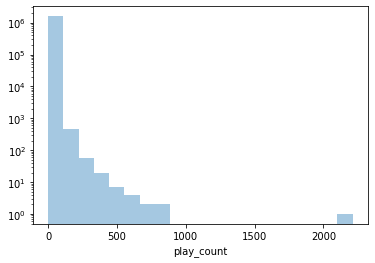

In [23]:
# histogram for play_count in log scale
df_final.fillna(value=0)
play_count_histogram = sns.distplot(df_final.play_count, kde=False, rug=False, bins=20)
play_count_histogram.set_yscale('log')

**Observations**
- The user_id and song_id are unique values. 
- Some users played a song more than once (i.e. 2x, 5x).

##### **Exploratory Data Analysis**

**Shape of the Data**

In [24]:
# check the data types 
df_final.dtypes

user_id         int64
song_id         int64
play_count      int64
title          object
release        object
artist_name    object
year            int64
dtype: object

In [25]:
# number of unique values in the df_final
df_final.nunique()

user_id        75579
song_id         5229
play_count       282
title           5082
release         3044
artist_name     1970
year              57
dtype: int64

**Observations**
- There are a lot of unique values in the df_final dataset. 
- Look into the specifics of the values that are unique.

**Is there a song that has been interacted with more than once by the same user?**

In [26]:
df_final.groupby(['user_id', 'song_id']).sum()

play_count  year
user_id song_id                  
0       392231            1  2003
        541321            3     0
        843090            1  2003
        889862            3     0
1       275060            1  1984
...                     ...   ...
76352   792989            1  2005
        846781            1  2005
        850320            1  2005
        866899            1  2005
        981573            1  2001

[1575883 rows x 2 columns]

In [27]:
df_final.groupby(['user_id', 'song_id']).count()['play_count'].sum()

1575883

**Oberservations**
- The sum is equal to the total number of observations. 
- This implies that there are only interactions between a pair of songs and a single user. 

In [28]:
# the most listened to song
df_final['song_id'].value_counts()

241964    8277
35140     7032
38957     6949
67669     6412
751776    6145
          ... 
851645     120
63568      120
925413     120
294490     120
153817     120
Name: song_id, Length: 5229, dtype: int64

In [29]:
df_final['user_id'].nunique()

75579

In [30]:
df_final['song_id'].nunique()

5229

**Observations**
- The song with song_id 241964 has been interacted with the most at 8277 times.
- There is a possibility that 75579 * 5229 = 395202591 interactions in the dataset. 
- Yet, we only have 1575883 entries, which might suggest that there are different users who interacted with a single song.
- It is noteworthy that multiple interactions for one song from various users is not a succinct indicator of popularity. 
- Just because a song received multiple interactions, does not mean that it is the song that should be recommended to users: there are many factors to consider. 
- A recommendation system that 

**Check for missing values**

In [63]:
df_final.isnull().sum()

user_id            0
song_id            0
play_count     48594
title              0
release            0
artist_name        0
year               0
dtype: int64

**Summary Statistics**

In [65]:
# summary statistics of 'play_count' variable 
df_final['play_count'].describe()

count    1.527289e+06
mean     1.608697e-01
std      2.799113e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e-01
max      1.000000e+00
Name: play_count, dtype: float64

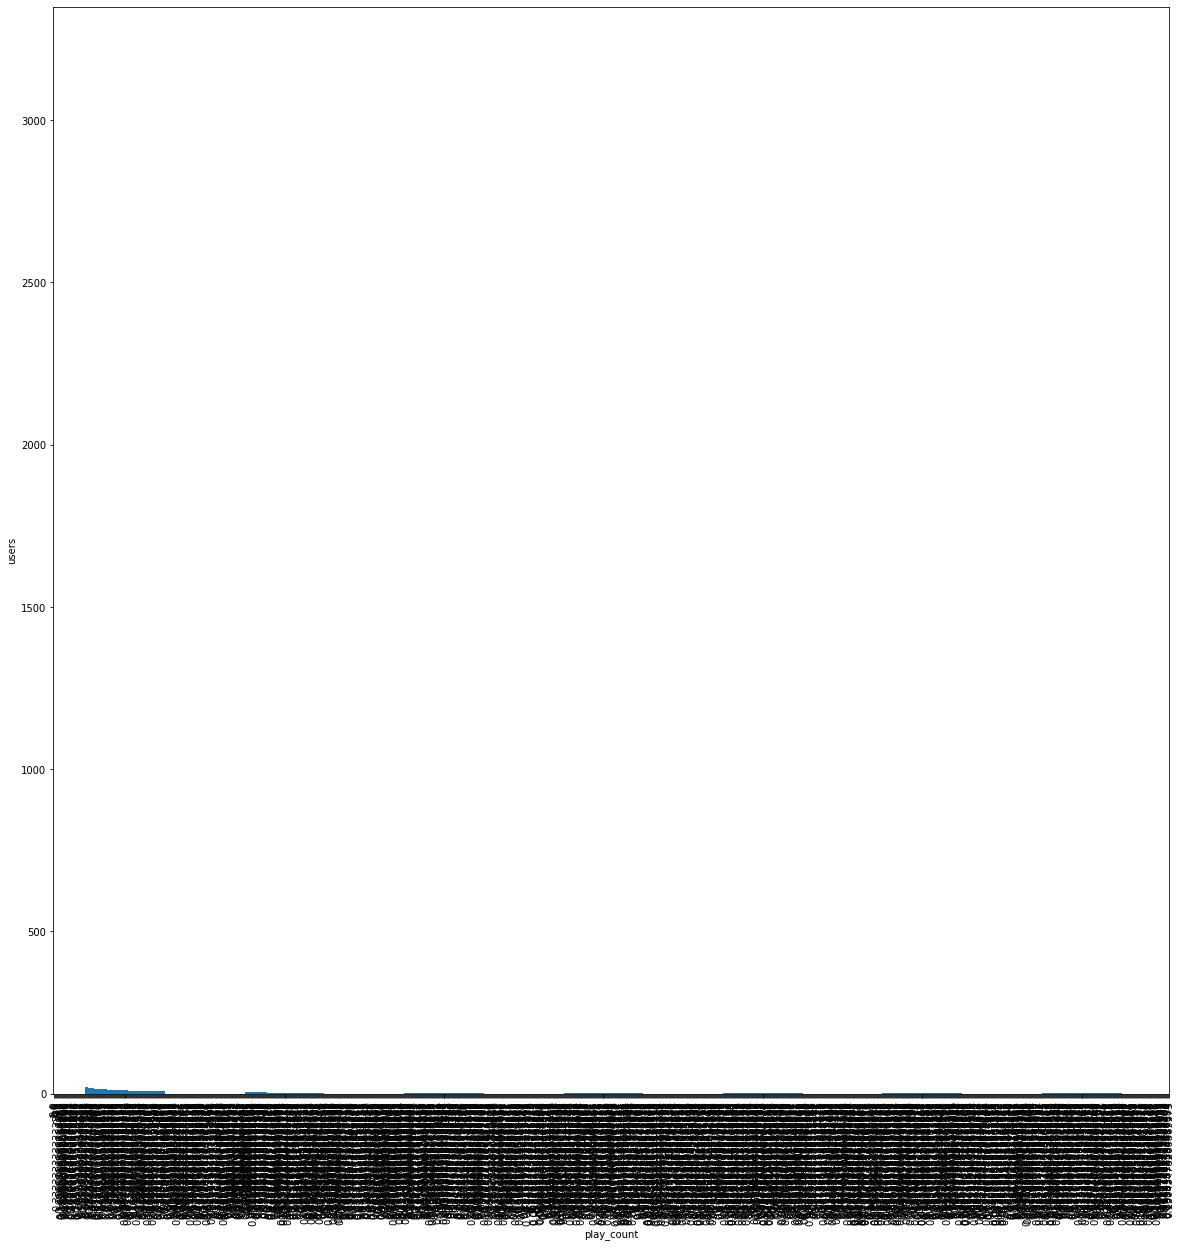

In [66]:
# create the bar plot and provide observations
# given a most liked or most disliked product

plt.figure(figsize = (20,20))
df_final[df_final['song_id'] == 241964]['play_count'].value_counts().plot(kind='bar')
plt.xlabel('play_count')
plt.ylabel('users')
plt.show()

Text(0.5, 1.0, 'Percent of songs played a given year')

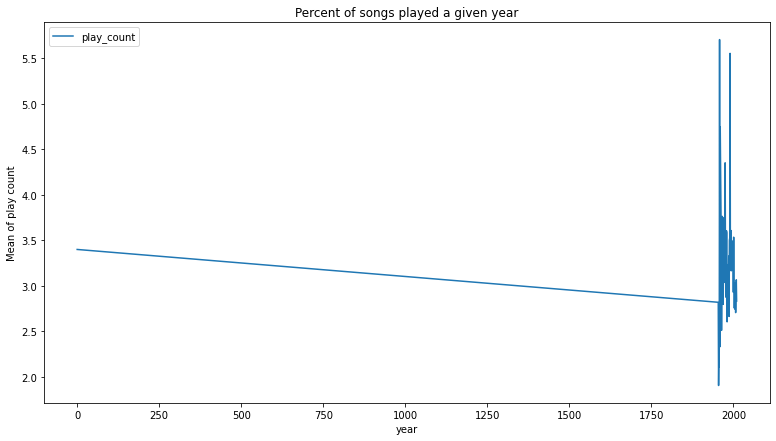

In [34]:
# line graph displaying play_count given each year by mean 
mean_df = df_final.groupby(['year']).mean()

listen_count_trend = mean_df[['play_count']].plot.line(figsize=(13,7))
listen_count_trend.set_ylabel('Mean of play count')
listen_count_trend.set_title('Percent of songs played a given year')

In [35]:
# filter data to show the most recent releases
this_year = df_final.loc[(df_final['year']==2010)]

# check if there are songs from the year 2010
this_year['year'].value_counts()

2010    56084
Name: year, dtype: int64

**Checking the number of unqiue users in the dataset**

In [36]:
# number of unique users in the dataset 
print('Number of unique USERS in the Raw data = ', df_final['user_id'].nunique())
print('Number of unique SONGS in Raw data = ', df_final['song_id'].nunique())

Number of unique USERS in the Raw data =  75579
Number of unique SONGS in Raw data =  5229


**Users with an appropriate number of song listen counts**


In [37]:
# top 10 users based on listen count of song(s)
most_listened = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_listened

user_id
75144    537
32542    518
61472    446
10807    435
31704    427
23297    424
23790    406
48273    401
6480     391
49507    389
dtype: int64

##### **Data preparation**

In [38]:
# check the number of unique USERS and SONGS in the final data and provide observations

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique SONGS in the final data = ', df_final['song_id'].nunique())
print('Number of COUNTS LISTENED in the final data = ', df_final['play_count'].sum)

The number of observations in the final data = 1575883
Number of unique USERS in the final data =  75579
Number of unique SONGS in the final data =  5229
Number of COUNTS LISTENED in the final data =  <bound method NDFrame._add_numeric_operations.<locals>.sum of 0          1
1          2
2          1
3          1
4          1
          ..
1999994    4
1999995    2
1999996    4
1999997    3
1999998    1
Name: play_count, Length: 1575883, dtype: int64>


##### **Data Normalization**

In [67]:
zscore = lambda x: (x-x.mean())/x.std()
the_norm_zscore = df_final.groupby('user_id').transform(zscore)
df_final.play_count = the_norm_zscore.play_count

df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,-0.360085,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.240056,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,-0.360085,Stronger,Graduation,Kanye West,2007
3,54961,83689,-0.360085,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,-0.360085,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [68]:
min_max = lambda x: (x - x.min()) / (x.max() - x.min())
the_norm_min_max = df_final.groupby('user_id').transform(min_max)
df_final.play_count = the_norm_min_max.play_count 

df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,0.000000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.142857,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [70]:
df_final.fillna(value=0)

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,0.000000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.142857,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
...,...,...,...,...,...,...,...
1999994,64590,359346,0.375000,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
1999995,64590,385009,0.125000,Ignorance (Album Version),Ignorance,Paramore,0
1999996,64590,392598,0.375000,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009
1999997,64590,393702,0.250000,What I've Done (Album Version),What I've Done,Linkin Park,2007


##### **Rank Based Recommendation System**

In [71]:
df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,17370,0.000000,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,45995,0.142857,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,82002,0.000000,Stronger,Graduation,Kanye West,2007
3,54961,83689,0.000000,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,129375,0.000000,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [72]:
# calculate the average listen count for each song 
average_count_listen = df_final.groupby('song_id').mean()['play_count']

# calculate the count of listen for each song
list_count_of_song = df_final.groupby('song_id').count()['play_count']

# create a dataframe with calculated average and count of listens
final_df = pd.DataFrame({'avg_rating':average_count_listen, 'list_count':list_count_of_song})

# sort the dataframe by average of ratings in the descending order
final_df = final_df.sort_values(by='avg_rating', ascending=False) 

final_df.head(100)


,avg_rating,list_count
song_id,,
3743,0.534310,156
284055,0.516810,134
842729,0.505630,224
406335,0.499071,257
851645,0.467486,120
...,...,...
515747,0.317711,508
838619,0.317085,576
732499,0.316739,155


**Word2vec recommender**


##### **Model 1: Rank-Based Recommendation System**

In [41]:
# calculate average listen counts
average_listen_counts = df_final.groupby('user_id').mean()['play_count']

# calculate the count of listens 
count_of_listen = df_final.groupby('user_id').count()['play_count']

# make a dataframe with the count and average of listens for a user
final_listen_df = pd.DataFrame({'avg_listen_counts':average_listen_counts, 'listen_count': count_of_listen})

#df_final['user_id'].drop_duplicates().sort_values()

In [42]:
final_listen_df.head(100)

,avg_listen_counts,listen_count
user_id,,
0,2.000000,4
1,1.000000,2
2,2.875000,8
3,3.250000,8
4,1.000000,8
...,...,...
95,1.166667,6
96,3.421053,19
97,2.264706,34


In [43]:
# function for top n users for a recommendation based on average ratings of restaurant
def top_n_user(df_final, n, min_interaction=50): 
    
    # find users with minimum number of interactions
    recommendations = df_final[df_final['listen_count'] > min_interaction]
    
    # sort values w.r.t average listen counts 
    recommendations = recommendations.sort_values(by='avg_listen_counts', ascending=False)
    
    return recommendations.index[:n]

**Recommending top 5 songs with 50 minimum interacitons based on play count(s)**

In [44]:
list(top_n_user(final_listen_df, 5, 50))

[45183, 2403, 22590, 62305, 65521]

**Recommending top 5 songs with 100 minimum interacitons based on play count(s)**

In [45]:
list(top_n_user(final_listen_df, 5, 100))

[62305, 22588, 32364, 20844, 21500]

### **Let us check the data types and and missing values of each column**

##### **Data Reduction**

In [47]:
# get the column containing the users
users = merged_df.user_id
# create a dictionary from users to their number of songs
ratings_count = dict()

# function to filter the data for users who have listened to a good count of songs
def sufficient_count_of_songs(): 
    for user in users:
    # if there already exists a user, just add 1 to the rating count
        if user in ratings_count:
            ratings_count[user] += 1
    # otherwise, set the rating count to 1
        else:
            ratings_count[user] = 1 
    some_ratings_count = list(ratings_count)[:200]
    print(some_ratings_count)
sufficient_count_of_songs()

[54961, 39877, 56522, 40874, 45012, 22570, 66678, 47087, 46575, 54498, 6958, 63855, 27018, 59353, 20639, 70730, 55837, 6647, 50286, 56576, 3204, 38632, 19147, 74048, 48241, 19194, 13178, 42347, 57055, 5416, 49549, 44537, 12898, 58003, 18808, 43278, 70892, 73298, 9415, 21487, 76143, 63872, 359, 24533, 20082, 43942, 34420, 60317, 53867, 12635, 33130, 68660, 45949, 35629, 49202, 54615, 49608, 38327, 45988, 70816, 75935, 34234, 3540, 18971, 7798, 49235, 72300, 65206, 22784, 41940, 17679, 58071, 384, 47801, 29430, 7952, 54091, 72841, 9670, 37560, 69683, 6937, 54439, 35957, 19076, 44618, 2282, 38800, 26436, 54164, 6285, 30346, 25492, 44689, 15550, 14046, 47803, 70178, 25651, 70000, 52925, 44648, 22447, 6872, 42650, 37000, 24267, 53923, 56544, 21274, 40553, 39887, 27881, 68345, 58076, 19568, 6888, 4351, 70647, 17831, 40583, 64176, 40543, 46525, 17192, 49395, 55758, 37086, 68099, 42302, 24524, 28077, 68048, 41638, 7320, 75095, 57655, 69800, 4383, 10723, 66723, 12383, 39814, 10374, 69499, 56100

In [48]:
from IPython.display import display
# function that groups songs by title and play_count with percentage of song counts listened
def group_songs_by_play_count():
    grouped_songs_df = merged_df.groupby(['title']).agg({'play_count': 'count'}).reset_index()
    grouped_songs_sum = grouped_songs_df['play_count'].sum()
    grouped_songs_df['percentage'] = grouped_songs_df['play_count'].div(grouped_songs_sum)*100
    final_grouped_songs_df = grouped_songs_df.sort_values(['play_count', 'title'], ascending = [0,1])
    display(final_grouped_songs_df)
group_songs_by_play_count()

,title,play_count,percentage
6836,Sehr kosmisch,8277,0.41385
8725,Undo,7032,0.35160
1964,Dog Days Are Over (Radio Edit),6949,0.34745
9496,You're The One,6729,0.33645
6498,Revelry,6145,0.30725
...,...,...,...
3363,Historia Del Portero,51,0.00255
6782,Scared,51,0.00255
2041,Don´t Leave Me Now,50,0.00250
2860,Ghosts (Toxic Avenger Mix),48,0.00240


In [49]:
# Check the shape of the data


## **Exploratory Data Analysis**

### **Let's check the total number of unique users, songs, artists in the data**

# Total number of unique user id

In [50]:
# display total number of unique user_id


Total number of unique song id

In [51]:
# display total number of unique song_id


Total number of unique artists

In [52]:
# display total number of unique artists


#### **Observations and Insights:__________**


### **Let's find out about the most interacted songs and interacted users**

Most interacted songs

Most interacted users

#### **Observations and Insights:_______**


Songs played in a year

In [53]:
count_songs = df_final.groupby('year').count()['title']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace=True)
count.tail()

,title
year,
2006,93695
2007,129689
2008,140010
2009,150485
2010,56084


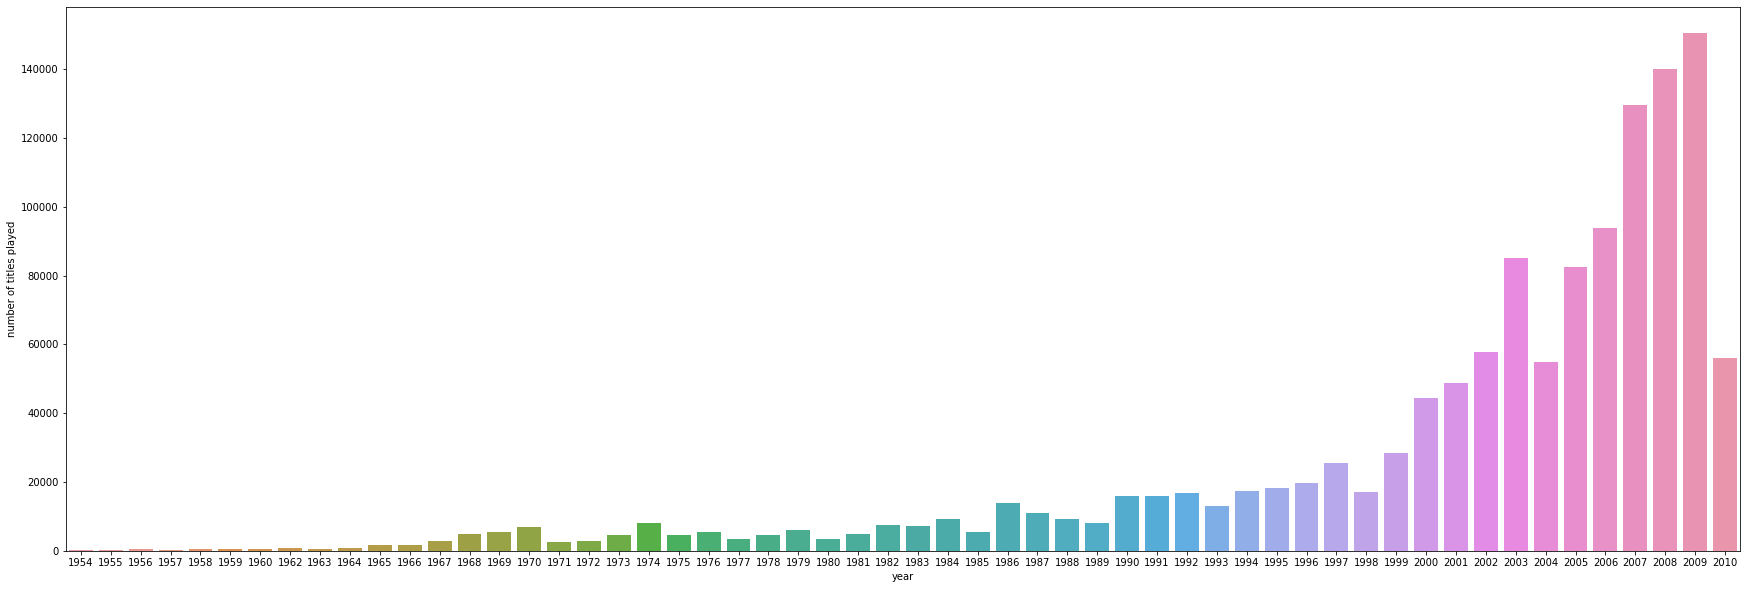

In [54]:
plt.figure(figsize=(30,10))
sns.barplot(x = count.index,
            y = 'title',
            data = count,
            estimator = np.median)
plt.ylabel('number of titles played') 
# Show the plot
plt.show()

**Observations**
- There are 1000000 entries. 
- The data contains 5 columns. 
- The data types are int64(1), object(4). 
- The dataset song_df uses less memory ~38.1 MB.

**Think About It:** What other insights can be drawn using exploratory data analysis?

## **Proposed approach**
**Potential techniques** - What different techniques should be explored?<br>
**Overall solution design** - What is the potential solution design?<br>
**Measures of success**- What are the key measures of success to compare different potential technqiues?<br>